- Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

- Import Packages

In [0]:
import pandas as pd
import numpy as np
import nltk
from gensim import corpora
from functools import reduce
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
spacy.load('en')
from spacy.lang.en import English


- Define stop words

In [0]:
parser = English()
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa", ))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

- Read data

In [0]:
clean_data = pd.read_csv('/content/drive/My Drive/ALDA-Project/cleaned_data.csv', index_col=0)
my_data = clean_data['new_msg'].dropna()

In [0]:
n_features = 500
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words= stop)

In [0]:
tf = vectorizer.fit_transform(my_data)
feature_names = vectorizer.get_feature_names()

In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

lsa = TruncatedSVD(10, algorithm = 'arpack')

lsa.fit(tf.astype(float))
output = lsa.transform(tf)

In [0]:
lsa.explained_variance_ratio_.sum()

0.17213218388673854

In [0]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [0]:
display_topics(lsa, feature_names, 10)


Topic 0:
ect enron com hou pm please corp thanks would message
Topic 1:
ect hou forwarded lon na ee enronxgate corp vince kaminski
Topic 2:
com enron www corp aol mail na net forwarded mailto
Topic 3:
enron corp na development et enronxgate ee kay america employee
Topic 4:
schedule final date hour iso start file type california id
Topic 5:
power energy market company price www gas california said state
Topic 6:
attached agreement please doc energy power report gas draft see
Topic 7:
deal thanks kay gas com price mann contract volume chris
Topic 8:
message original pm intended power doc recipient october kay mail
Topic 9:
fax eb houston sara texas america phone north smith street


- Hyper Parameter Tuning

In [0]:
class MyLSAWithEVRScorer(TruncatedSVD):

    def score(self, X, y=None):

        # You can change the options passed to perplexity here
        ls = super(MyLSAWithEVRScorer, self).fit(X)
        score = ls.explained_variance_ratio_.sum()
        print(score)
        # Since perplexity is lower for better, so we do negative
        return score

In [0]:
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_iter': [5, 10, 15, 20], 'algorithm': ['arpack', 'randomized']}

# Init the Model
new_lsa = MyLSAWithEVRScorer()

# Init Grid Search Class
model = GridSearchCV(new_lsa, param_grid=search_params)

# Do the Grid Search
model.fit(tf.astype('float64'))
#model

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.05543508579983386
0.0780553676616617
0.0622994203500542
0.05543508579983407
0.0780553676616618
0.062299420350054875
0.0554350857998341
0.0780553676616618
0.06229942035005431
0.0554350857998339
0.07805536766166174
0.06229942035005474
0.05543487804906495
0.0780553622438459
0.062299475863004355
0.055435084776048235
0.07805536764238409
0.062299420345821796
0.05543508580005598
0.07805536766166152
0.062299420350052044
0.055435085799834014
0.0780553676616613
0.062299420350054965


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MyLSAWithEVRScorer(algorithm='randomized',
                                          n_components=2, n_iter=5,
                                          random_state=None, tol=0.0),
             iid='warn', n_jobs=None,
             param_grid={'algorithm': ['arpack', 'randomized'],
                         'n_iter': [5, 10, 15, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
model.best_params_

{'algorithm': 'randomized', 'n_iter': 15}

In [0]:
model.best_estimator_

MyLSAWithEVRScorer(algorithm='randomized', n_components=2, n_iter=15,
                   random_state=None, tol=0.0)

In [0]:
# save the model to disk
import pickle
filename = 'lsa_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [0]:
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
  print("%0.15f (+/-%0.15f) for %r"% (mean, std * 2, params))

0.065263272250294 (+/-0.018939039475459) for {'algorithm': 'arpack', 'n_iter': 5}
0.065263272250294 (+/-0.018939039475459) for {'algorithm': 'arpack', 'n_iter': 10}
0.065263272250294 (+/-0.018939039475459) for {'algorithm': 'arpack', 'n_iter': 15}
0.065263272250294 (+/-0.018939039475459) for {'algorithm': 'arpack', 'n_iter': 20}
0.065263219698116 (+/-0.018939166760843) for {'algorithm': 'randomized', 'n_iter': 5}
0.065263271901194 (+/-0.018939040167359) for {'algorithm': 'randomized', 'n_iter': 10}
0.065263272250367 (+/-0.018939039475306) for {'algorithm': 'randomized', 'n_iter': 15}
0.065263272250294 (+/-0.018939039475459) for {'algorithm': 'randomized', 'n_iter': 20}


In [0]:
model.cv_results_['std_test_score']

array([0.00946952, 0.00946952, 0.00946952, 0.00946952, 0.00946958,
       0.00946952, 0.00946952, 0.00946952])

In [0]:
model.cv_results_['params']

[{'algorithm': 'arpack', 'n_iter': 5},
 {'algorithm': 'arpack', 'n_iter': 10},
 {'algorithm': 'arpack', 'n_iter': 15},
 {'algorithm': 'arpack', 'n_iter': 20},
 {'algorithm': 'randomized', 'n_iter': 5},
 {'algorithm': 'randomized', 'n_iter': 10},
 {'algorithm': 'randomized', 'n_iter': 15},
 {'algorithm': 'randomized', 'n_iter': 20}]

In [0]:
import gensim
w2v_model = gensim.models.Word2Vec.load("/content/drive/My Drive/ALDA-Project/w2v-model.bin")

In [0]:
kmin, kmax = 1, 30

from sklearn import decomposition
topic_models = []
for k in range(kmin,kmax+1):
    print("Applying LSA for k=%d ..." % k )
    model = decomposition.TruncatedSVD(n_components=k, n_iter=10 ) 
    W = model.fit_transform(tf )
    H = model.components_    
    topic_models.append( (k,W,H) )



Applying LSA for k=1 ...
Applying LSA for k=2 ...
Applying LSA for k=3 ...
Applying LSA for k=4 ...
Applying LSA for k=5 ...
Applying LSA for k=6 ...
Applying LSA for k=7 ...
Applying LSA for k=8 ...
Applying LSA for k=9 ...
Applying LSA for k=10 ...
Applying LSA for k=11 ...
Applying LSA for k=12 ...
Applying LSA for k=13 ...
Applying LSA for k=14 ...
Applying LSA for k=15 ...
Applying LSA for k=16 ...
Applying LSA for k=17 ...
Applying LSA for k=18 ...
Applying LSA for k=19 ...
Applying LSA for k=20 ...
Applying LSA for k=21 ...
Applying LSA for k=22 ...
Applying LSA for k=23 ...
Applying LSA for k=24 ...
Applying LSA for k=25 ...
Applying LSA for k=26 ...
Applying LSA for k=27 ...
Applying LSA for k=28 ...
Applying LSA for k=29 ...
Applying LSA for k=30 ...


In [0]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [0]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms


In [0]:
from itertools import combinations
k_values = []
coherences = []
terms = feature_names
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms , H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


K=01: Coherence=0.3333
K=02: Coherence=0.3498
K=03: Coherence=0.3128
K=04: Coherence=0.2998
K=05: Coherence=0.2907
K=06: Coherence=0.2854
K=07: Coherence=0.2827
K=08: Coherence=0.2794
K=09: Coherence=0.2729
K=10: Coherence=0.2716
K=11: Coherence=0.2764
K=12: Coherence=0.2699
K=13: Coherence=0.2662
K=14: Coherence=0.2662
K=15: Coherence=0.2653
K=16: Coherence=0.2611
K=17: Coherence=0.2575
K=18: Coherence=0.2566
K=19: Coherence=0.2531
K=20: Coherence=0.2561
K=21: Coherence=0.2542
K=22: Coherence=0.2535
K=23: Coherence=0.2530
K=24: Coherence=0.2522
K=25: Coherence=0.2508
K=26: Coherence=0.2487
K=27: Coherence=0.2481
K=28: Coherence=0.2465
K=29: Coherence=0.2438
K=30: Coherence=0.2437


In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [0]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: ect, enron, com, hou, pm, please, corp, thanks, would, message
Topic 02: ect, hou, forwarded, lon, na, ee, enronxgate, corp, vince, kaminski


Back to reality

In [0]:
from nltk.tokenize import RegexpTokenizer
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
def preprocess_data(doc_set):
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    texts = []
    for i in doc_set:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        texts.append(stopped_tokens)
    return texts

In [0]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [0]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [0]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [0]:
temp = preprocess_data(my_data)

In [0]:
start,stop,step=2,12,1
number_of_topics = 10
#plot_graph(temp,start,stop,step)
dictionary,doc_term_matrix=prepare_corpus(temp)
#model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            #stop, start, step)

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,temp, stop, start, step)

In [0]:
n = 1
for k in model_list:
  with open("/content/drive/My Drive/ALDA-Project/lsa_gensim_model_" + str(n), 'wb') as file:
    pickle.dump(k, file)
    n = n + 1

In [0]:
k_values = range(2, 12,1)
'''coherence_values = [0.48828408069994317,
 0.48827943451740297,
 0.48827943451740297,
 0.4882622189184489,
 0.48831383420012575,
 0.4882622189184489,
 0.4882622189184489,
 0.48834955370393596,
 0.48834955370393596,
 0.4883394159475956]'''

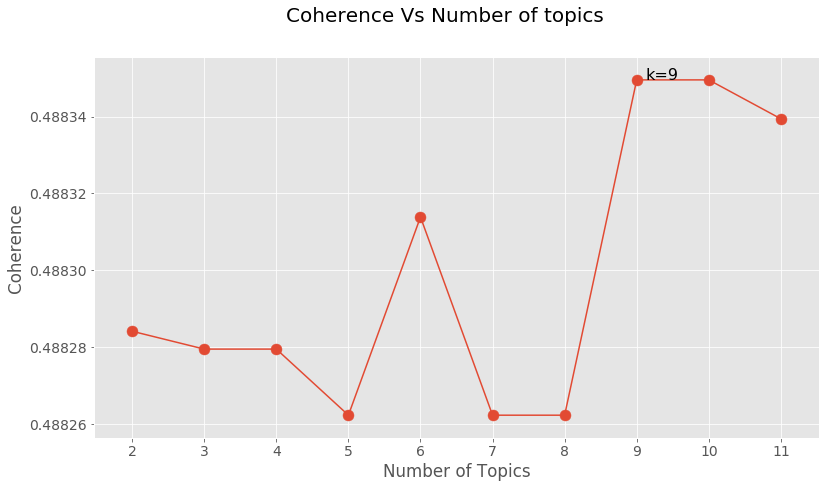

In [9]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

coherences = coherence_values
fig = plt.figure(figsize=(13,7))
fig.suptitle('Coherence Vs Number of topics', fontsize=20)
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")

plt.scatter( k_values, coherences, s=120)

ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
plt.savefig('LSA_HP.png')
plt.show()

In [0]:
import pickle
with open("/content/drive/My Drive/ALDA-Project/lsa_gensim_model_coh_vals", 'wb') as file:
    pickle.dump(coherence_values, file)